# Classification of NBA players role

### Dataset description

We will be working with a dataset of NBA basketball players data (you can get from https://www.kaggle.com/jacobbaruch/nba-player-of-the-week the full dataset).

The provided data is a subset of the full dataset containing the players that have the role of Center and of Point Guard. For each player the dataset contains the height, weight and age.

From Wikipedia:

The **Center** (C), also known as the five, or the big man, is one of the five positions in a regular basketball game. The center is normally the tallest player on the team, and often has a great deal of strength and body mass as well. In the NBA, the center is usually 6' 10" (2.08 m) or taller and usually weighs 240 lbs (109 kg) or more. 

**Point Guards** (PG, a.k.a. as "play maker") are expected to run the team's offense by controlling the ball and making sure that it gets to the right players at the right time. In the NBA, point guards are usually about 6' 3" (1.93 m) or shorter, and average about 6' 2" (1.88 m). Having above-average size (height, muscle) is considered advantageous, although size is secondary to situational awareness, speed, quickness, and ball handling skills. Shorter players tend to be better dribblers since they are closer to the floor, and thus have better control of the ball while dribbling. 


As it is clear from the description, the height and weight of the player are good hints to predict their role and in this lab we will exploit this features to estimate the role.


### Three features (regressors) are considered for this dataset:


1) Height in cm

2) Weight in kg

3) Age in years

We first import all the packages that are needed.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import csv

import numpy as np
import scipy as sp
import sklearn as sl
from scipy import stats
from sklearn import datasets
from sklearn import linear_model

# Perceptron
We will implement the perceptron algorithm and use it to learn a halfspace.

Load the dataset and then split in training set and test set (the training set is typically larger, you can use a 75% tranining 25% test split) after applying a random permutation to the datset.

A) Load dataset and perform permutation

In [2]:
#load the dataset
filename = 'data/NBA.csv' # do not change the file name or content
NBA = csv.reader(open(filename, newline=''), delimiter=',')

header = next(NBA) #skip first line
print(header)

dataset = list(NBA)
for i in range(len(dataset)):
    dataset[i] = [int(x) for x in dataset[i]]
    
dataset = np.asarray(dataset)

X = dataset[:,1:4] #columns 1,2,3 contain the features
Y = dataset[:,0]  # column 0: labels

Y = Y*2-1  # set labels to -1, 1 as required by perceptron implementation

m = dataset.shape[0]
permutation = np.random.permutation(m) # random permurtation

X = X[permutation]
Y = Y[permutation]

['Position', 'Height cm', 'kg', 'Age']


We are going to classify class "1" (Center) vs class "-1" (Point Guard)

In [3]:
#Divide in training and test: make sure that your training set
#contains at least 10 elements from class 1 and at least 10 elements
#from class -1! If it does not, modify the code so to apply more random
#permutations (or the same permutation multiple times) until this happens.
#IMPORTANT: do not change the random seed.

#m_training needs to be the number of samples in the training set
m_training = int(X.shape[0]*3/4)

#m_test needs to be the number of samples in the test set
m_test = int(X.shape[0]/4)

#X_training = instances for training set
X_training = X[:m_training,:]
#Y_training = labels for the training set
Y_training = Y[:m_training]

#X_test = instances for test set
X_test =  X[m_training:,]
#Y_test = labels for the test set
Y_test = Y[m_training:]

print(Y_training) #to make sure that Y_training contains both 1 and -1
print('m_test'+str(m_test))


print("Shape of dataset: " + str(X.shape))
print("Shape of training set: " + str(X_training.shape))
print("Shape of test set: " + str(X_test.shape))

[-1 -1  1 -1  1  1 -1 -1 -1  1 -1 -1  1  1  1  1 -1 -1 -1 -1  1 -1 -1  1
  1  1 -1  1  1 -1  1 -1  1  1  1 -1 -1 -1  1 -1 -1  1  1 -1  1  1 -1 -1
  1  1 -1 -1  1 -1  1 -1 -1  1  1 -1  1 -1  1  1  1  1 -1  1 -1 -1 -1  1
 -1 -1  1  1 -1 -1  1  1 -1 -1  1 -1 -1  1 -1  1 -1  1 -1  1 -1  1 -1  1
  1  1 -1  1 -1  1  1  1 -1  1  1 -1  1  1  1  1  1  1 -1 -1  1  1  1  1
  1  1 -1  1 -1  1  1  1  1  1  1 -1  1  1 -1 -1  1  1 -1  1 -1 -1 -1  1
 -1  1 -1 -1  1  1  1  1  1  1  1  1 -1  1 -1 -1  1  1  1  1  1 -1 -1  1
 -1 -1 -1  1  1  1 -1 -1 -1 -1  1  1 -1  1  1 -1 -1  1  1 -1  1  1  1  1
 -1  1  1]
m_test65
Shape of dataset: (260, 3)
Shape of training set: (195, 3)
Shape of test set: (65, 3)


In [4]:
#add a 1 to each sample (homogeneous coordinates)
X_training = np.hstack((np.ones((m_training,1)),X_training))
X_test = np.hstack((np.ones((m_test,1)),X_test))

**TO DO** Now complete the function *perceptron*. Since the perceptron does not terminate if the data is not linearly separable, your implementation should return the desired output (see below) if it reached the termination condition seen in class or if a maximum number of iterations have already been run, where one iteration corresponds to one update of the perceptron weights. In case the termination is reached because the maximum number of iterations have been completed, the implementation should return **the best model** seen up to now.

The input parameters to pass are:
- $X$: the matrix of input features, one row for each sample
- $Y$: the vector of labels for the input features matrix X
- $max\_num\_iterations$: the maximum number of iterations for running the perceptron

The output values are:
- $best\_w$: the vector with the coefficients of the best model
- $best\_error$: the *fraction* of missclassified samples for the best model

In [5]:
def perceptron(X, Y, max_num_iterations):
    #coefficient initialization
    w = np.zeros(X.shape[1])
    best_w = w
    nsamples = X.shape[0]
    best_error = nsamples+1
    
    index_miss = -1
    n_misses = 0
    
    for i in np.arange(max_num_iterations):
        #update coefficients
        w = w+ Y[index_miss]*X[index_miss,:]
        index_miss = -1
        n_misses = 0
        for i in range(nsamples):
            #have data in random order
            permutation = np.random.permutation(nsamples)
            x = X[permutation[i],:]
            y = Y[permutation[i]]
            prediction = np.sign(np.dot(w,x))
            if (prediction != y):
                index_miss = permutation[i]
                n_misses += 1
        if n_misses < best_error:
            best_error = n_misses
            best_w = w
        
    best_error = best_error/nsamples
    #return the best coefficient and the best error
    return best_w, best_error

Now we use the implementation above of the perceptron to learn a model from the training data using 100 iterations and print the error of the best model we have found.

In [6]:
#now run the perceptron for 100 iterations
w_found, error = perceptron(X_training,Y_training, 100)
print("Training Error of perpceptron (100 iterations): " + str(error))

Training Error of perpceptron (100 iterations): 0.09230769230769231


In [7]:
#now use the w_found to make predictions on test dataset
num_errors = 0
for i in range(m_test):
    x = X_test[i,:]
    y = Y_test[i]
    pred = np.sign(np.dot(w_found,x))
    if (pred != y):
        num_errors += 1

true_loss_estimate = num_errors/m_test  # error rate on the test set
#NOTE: you can avoid using num_errors if you prefer, as long as true_loss_estimate is correct
print("Test Error of perpceptron (100 iterations): " + str(true_loss_estimate))

Test Error of perpceptron (100 iterations): 0.12307692307692308


The train error is slightly smaller than the test one, since the learning procedure consists in 'showing' the trainset to the algorithm many times, and in minimizing the error on this set. The  test set consists in new data, so the number of missclassified samples is usually bigger in this set.




In [8]:
#now run the perceptron for 5000 iterations here!

w_found, error = perceptron(X_training,Y_training, 5000)
print("Training Error of perpceptron (5000 iterations): " + str(error))
num_errors = 0.
for i in range(m_test):
    x = X_test[i,:]
    y = Y_test[i]
    pred = np.sign(np.dot(w_found,x))
    if (pred != y):
        num_errors += 1

true_loss_estimate = num_errors/m_test
print(true_loss_estimate)

Training Error of perpceptron (5000 iterations): 0.020512820512820513
0.09230769230769231


Although the differences from the previous case (100 iteration) are not drammatic, now the training error is slightly smaller and the test exactly the same as before. This is because the algorithm has already reached the minimum error in 100 iterations and so it doesn't improve for larger number of iterations.  The error is different than 0 because the data is not linearly separable.

# Logistic Regression
Now we use logistic regression, as implemented in Scikit-learn, to predict labels. We will also plot the decision region of logistic regression.

We first load the dataset again.

In [9]:
filename = 'data/NBA.csv'
NBA = csv.reader(open(filename, newline=''), delimiter=',')

header = next(NBA)
print(header)

dataset = list(NBA)
for i in range(len(dataset)):
    dataset[i] = [int(x) for x in dataset[i]]
    
dataset = np.asarray(dataset)

X = dataset[:,1:]
Y = dataset[:,0]

Y = Y*2-1  # set labels to {-1, 1} as required by perceptron implementation

m = dataset.shape[0]
permutation = np.random.permutation(m)

X = X[permutation]
Y = Y[permutation]

['Position', 'Height cm', 'kg', 'Age']


As for the previous part, divide the data into training and test (75%-25%) and add a 1 as first component to each sample.

In [10]:
#Divide in training and test: make sure that your training set
#contains at least 10 elements from class 1 and at least 10 elements
#from class -1! If it does not, modify the code so to apply more random
#permutations (or the same permutation multiple times) until this happens.
#IMPORTANT: do not change the random seed.
m_training = int(X.shape[0]*3/4)
m_test = int(X.shape[0]/4)

X_training = X[:m_training,:]
Y_training = Y[:m_training]

X_test = X[m_training:,]
Y_test = Y[m_training:]

X_training = np.hstack((np.ones((m_training,1)),X_training))
X_test = np.hstack((np.ones((m_test,1)),X_test))

To define a logistic regression model in Scikit-learn use the instruction

$linear\_model.LogisticRegression(C=1e5)$

($C$ is a parameter related to *regularization*, a technique that
we will see later in the course. Setting it to a high value is almost
as ignoring regularization, so the instruction above corresponds to the
logistic regression you have seen in class.)

To learn the model you need to use the $fit(...)$ instruction and to predict you need to use the $predict(...)$ function. See the Scikit-learn documentation for how to use it.

In [11]:
#part on logistic regression for 2 classes
logreg = linear_model.LogisticRegression(C=1e5,solver='lbfgs')

#learn from training set

logreg.fit(X_training, Y_training)

#predict on training set
predict_trainset = logreg.predict(X_training)

#print the error rate = fraction of missclassified samples
error_rate_training = 0
for i in np.arange(len(Y_training)):
    if predict_trainset[i]!=Y_training[i]:
        error_rate_training += 1
error_rate_training = error_rate_training / m_training
print("Error rate on training set: "+str(error_rate_training))

#predict on test set
predict_testset = logreg.predict(X_test)

#print the error rate = fraction of missclassified samples
error_rate_test = 0 
for i in range(len(Y_test)):
    if predict_testset[i]!=Y_test[i]:
        error_rate_test += 1
error_rate_test = error_rate_test / m_test
print("Error rate on test set: " + str(error_rate_test))

Error rate on training set: 0.046153846153846156
Error rate on test set: 0.1076923076923077


In [12]:
#to make the plot we need to reduce the data to 2D, so we choose two features
features_list = ['height', 'weight', 'age']
labels_list = ['Center', 'Point guard']

index_feature1 = 0 # height
index_feature2 = 1 # weight
features = [index_feature1, index_feature2]

feature_name0 = features_list[features[0]]
feature_name1 = features_list[features[1]]

X_reduced = X[:,features]

X_training = X_reduced[:m_training,:]
Y_training = Y[:m_training]


X_test = X_reduced[m_training:,:]
Y_test = Y[m_training:]

Now learn a model using the training data and measure the performances.

In [13]:
# learning from training data
#same as before

logreg.fit(X_training, Y_training)

#predict on training set
predict_trainset = logreg.predict(X_training)

#print the error rate = fraction of missclassified samples
error_rate_training = 0
for i in range(len(Y_training)):
    if predict_trainset[i]!=Y_training[i]:
        error_rate_training += 1
error_rate_training = error_rate_training / m_training
print("Error rate on training set: "+str(error_rate_training))

#predict on test set
predict_testset = logreg.predict(X_test)

#print the error rate = fraction of missclassified samples
error_rate_test = 0 
for i in range(len(Y_test)):
    if predict_testset[i]!=Y_test[i]:
        error_rate_test += 1
error_rate_test = error_rate_test / m_test
print("Error rate on test set: " + str(error_rate_test))

Error rate on training set: 0.046153846153846156
Error rate on test set: 0.1076923076923077


I selected height and weight, since they are the most relevant features in determining the role of the player. <br>
The results are very similar as before, proving that these two features make the role of the player. The age is as important in this.

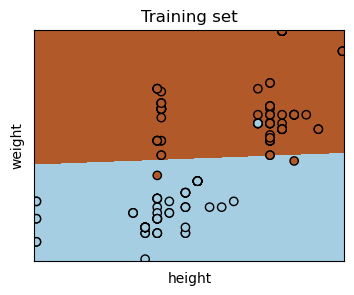

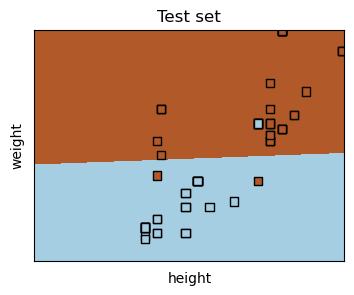

In [14]:
# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].

# NOTICE: This visualization code has been developed for a "standard" solution of the notebook, 
# it could be necessary to make some fixes to adapt to your implementation

h = .02  # step size in the mesh
x_min, x_max = X_reduced[:, 0].min() - .5, X_reduced[:, 0].max() + .5
y_min, y_max = X_reduced[:, 1].min() - .5, X_reduced[:, 1].max() + .5
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

Z = logreg.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)

plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the training points
plt.scatter(X_training[:, 0], X_training[:, 1], c=Y_training, edgecolors='k', cmap=plt.cm.Paired)
plt.xlabel(feature_name0)
plt.ylabel(feature_name1)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('Training set')

plt.show()

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(4, 3))
plt.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired)

# Plot also the test points 
plt.scatter(X_test[:, 0], X_test[:, 1], c=Y_test, edgecolors='k', cmap=plt.cm.Paired, marker='s')
plt.xlabel(feature_name0)
plt.ylabel(feature_name1)

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('Test set')

plt.show()